## Reading the .csv containing the file names and the steering angles

### Loading the file names  and steering angles into samples
### Splitting samples into train and validation samples

In [3]:
def  extractFileName ( abs_path):

    import os
    if os.name == "nt":
        split_char = '\\' 
    else:
        split_char = '/' 
    if '\\' in abs_path:
        # "  Windows Path " 
        image_name = abs_path.split ('\\')[-3] \
                            + split_char + abs_path.split ('\\')[-2] \
                            + split_char + abs_path.split ('\\')[-1]

    else:
        # "  Unix Path " 
        image_name = abs_path.split ('/')[-3] \
                            + split_char + abs_path.split ('/')[-2] \
                            + split_char + abs_path.split ('/')[-1]

    return image_name

#### Defining the resize shape of the images ( this parameter will be used also in the Generator and in the Model definition)

In [4]:
resized_shape = 128

In [5]:
## LOADING ALL IMAGES CENTER, LEFT, RIGHT IN A TWO DIMENSIONAL ARRAY:
## ( IMAGE, STEERING ANGLE )
## EVERYTHING WILL BE KEPT IN MEMORY TO SPEED DATA FLUSHING BETWEEN CPU AND GPU

### Defining the PyTable

In [37]:
from  tables import *
import tables
hdf5_file.close()

In [38]:
hdf5_file = open_file("./data/samples.npy", mode = "w", title = "Samples")


In [39]:
data_order = 'tf'  # 'th' for Theano, 'tf' for Tensorflow
img_dtype = tables.UInt8Atom()  # dtype in which the images will be saved
# check the order of data and chose proper data shape to save images
if data_order == 'th':
    data_shape = ( 0,3, resized_shape, resized_shape)
elif data_order == 'tf':
    data_shape = ( 0,resized_shape, resized_shape, 3)
    

####h5file.create_array(h5file.root, 'steering_angle', train_labels)

### Defining the two objects as images container:


In [40]:
train_storage = hdf5_file.create_earray(hdf5_file.root, 'train_img', img_dtype, shape=data_shape)
val_storage = hdf5_file.create_earray(hdf5_file.root, 'val_img', img_dtype, shape=data_shape)
traing_steering = hdf5_file.create_earray(hdf5_file.root, 'traing_steering', img_dtype, shape=(0,1))
val_steering = hdf5_file.create_earray(hdf5_file.root, 'val_steering', img_dtype, shape=(0,1))



In [19]:
# Load test images
import cv2
import numpy as np
test_images = []

image = cv2.imread('./test_images/center1.jpg')
image = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image,(resized_shape,resized_shape ))     
train_storage.append(image[None])

In [20]:
train_storage.shape

(1, 128, 128, 3)

In [21]:
image.shape

(128, 128, 3)

In [23]:
import os
import csv
import cv2
import numpy as np
import glob

print ( "Starting .... ")
samples_list = []
center_image_before = None
for name in glob.glob("./data/run1.csv"):
    print ( "Reading from logfile = " + name)
    with open(name)  as csvfile:
            reader = csv.reader(csvfile)
            for line in reader:
                # STEERING ANGLE CALCULATION
                samples_list.append([extractFileName( line[0]),\
                                     extractFileName( line[1]),\
                                     extractFileName( line[2]),\
                                     float(line[3])])
                
samples_list = np.array(samples_list)

from random import shuffle
shuffle(samples_list)

train_list = samples_list[0:int(0.8*len(samples_list))]

val_list = samples_list[int(0.8*len(samples_list)):int(1.0*len(samples_list))]


print ("\n\nThere are {} images in total ".format(len(samples_list)))
print ("....splitted into training images = {}  ".format(len(train_list)))
print ("                  val images      = {}  ".format(len(val_list)))


Starting .... 
Reading from logfile = ./data/run1.csv


There are 1779 images in total 
....splitted into training images = 1423  
                  val images      = 356  


In [24]:
def data_preprocess(line):
        preprocessed_samples=[]
        # STEERING ANGLE CALCULATION
        correction = 0.03 # this is a parameter to tune
        center_steering = float(line[3])
        left_steering   = center_steering + correction
        right_steering  = center_steering - correction

        # CENTER IMAGE
        center_image = cv2.imread(extractFileName( line[0]))
        center_image = cv2.cvtColor (center_image, cv2.COLOR_BGR2RGB)
        center_image = cv2.resize(center_image,(resized_shape,resized_shape ))
        preprocessed_samples.append([center_image, center_steering ])

        #   LEFT IMAGE
        left_image = cv2.imread(extractFileName( line[1]))
        left_image = cv2.cvtColor (left_image, cv2.COLOR_BGR2RGB)
        left_image = cv2.resize(left_image,(resized_shape,resized_shape ))
        preprocessed_samples.append([left_image, left_steering ])

        #   RIGHT IMAGE
        right_image = cv2.imread(extractFileName( line[2]))
        right_image = cv2.cvtColor (right_image, cv2.COLOR_BGR2RGB)
        right_image = cv2.resize(right_image,(resized_shape,resized_shape ))
        preprocessed_samples.append([right_image, right_steering ])


        ###
        ### IMAGE AUGMENTATION
        ###
        # augmented center image
        preprocessed_samples.append([cv2.flip(center_image,1), center_steering*-1.0 ])

        # augmented left image
        preprocessed_samples.append([cv2.flip(left_image  ,1), left_steering  *-1.0] )

        # augmented right image
        preprocessed_samples.append([cv2.flip(right_image,1),  right_steering *-1.0] )
        
#         print ( "here 1 {}".format( np.array(preprocessed_samples).shape))
        return np.array(preprocessed_samples)

In [52]:
http://machinelearninguru.com/deep_learning/data_preparation/hdf5/hdf5.html
    
import os
import csv
import cv2
import numpy as np
import glob

print ( "Starting Preprocessing the images  .... ")
train_samples      =  np.array([]).reshape(0,2)
validation_samples =  np.array([]).reshape(0,2)

for i,sample_line in enumerate(train_list):
   for output in data_preprocess(sample_line):
        train_storage.append(output[0][None])
        traing_steering.append(output[1][None]))
   if i% 1000 == 0 and i> 0 : print(".. training samples processed {}".format(i))     
   
for i,sample_line in enumerate(val_list):
   for output in data_preprocess(sample_line):
        val_storage.append(output[0][None])
   if i% 1000 == 0 and i> 0 : print(".. validation samples processed {}".format(i))     




print ("\nTotal training samples {}x{} after augmentation and preprocessing : {} "\
       .format(resized_shape,resized_shape,\
        str(len(train_storage)) ))
print ("\nTotal validation samples {}x{} after augmentation and preprocessing : {} "\
       .format(resized_shape,resized_shape,\
        str(len(val_storage)) ))
print ( "... completed")


SyntaxError: invalid syntax (<ipython-input-52-d825030247eb>, line 14)

In [214]:
# import os
# import csv
# import cv2
# import numpy as np
# import glob

# print ( "Starting .... ")
# samples = []
# center_image_before = None
# for name in glob.glob("./data/run1.csv"):
#     print ( "Reading from logfile = " + name)
#     with open(name)  as csvfile:
#             reader = csv.reader(csvfile)
#             for line in reader:
#                 # STEERING ANGLE CALCULATION
#                 correction = 0.03 # this is a parameter to tune
#                 center_steering = float(line[3])
#                 left_steering   = center_steering + correction
#                 right_steering  = center_steering - correction
                
#                 # CENTER IMAGE
#                 center_image = cv2.imread(extractFileName( line[0]))
#                 center_image = cv2.cvtColor (center_image, cv2.COLOR_BGR2RGB)
#                 center_image = cv2.resize(center_image,(resized_shape,resized_shape ))
#                 samples.append([center_image, center_steering ])
                
#                 #   LEFT IMAGE
#                 left_image = cv2.imread(extractFileName( line[1]))
#                 left_image = cv2.cvtColor (left_image, cv2.COLOR_BGR2RGB)
#                 left_image = cv2.resize(left_image,(resized_shape,resized_shape ))
#                 samples.append([left_image, left_steering ])
                
#                 #   RIGHT IMAGE
#                 right_image = cv2.imread(extractFileName( line[2]))
#                 right_image = cv2.cvtColor (right_image, cv2.COLOR_BGR2RGB)
#                 right_image = cv2.resize(right_image,(resized_shape,resized_shape ))
#                 samples.append([right_image, right_steering ])

                
#                 ###
#                 ### IMAGE AUGMENTATION
#                 ###
#                 # augmented center image
#                 samples.append([cv2.flip(center_image,1), center_steering*-1.0 ])

#                 # augmented left image
#                 samples.append([cv2.flip(left_image  ,1), left_steering  *-1.0] )

#                 # augmented right image
#                 samples.append([cv2.flip(right_image,1),  right_steering *-1.0] )

                
#                 ###
#                 ### IMAGE AUGMENTATION 2 - 
#                 ### Adding images of frames before... with the actual steering wheel angle
#                 if center_image_before is not None:
#                     samples.append([center_image_before, center_steering ])
 
#                 center_image_before = center_image
    

# samples =np.array(samples)
                
# print ("\nTotal samples {}x{} loaded in memory  : {} , size occupied in memory : {} Mb"\
#        .format(resized_shape,resized_shape,\
#         str(len(samples)*3), int(samples.nbytes/8/1024)) )

# from sklearn.model_selection import train_test_split
# train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# print ("\nTrain samples = {}".format(train_samples.shape[0]*3))
# print ("\nValidation samples  = {}".format(validation_samples.shape[0]*3))


Starting .... 
Reading from logfile = ./data/run1.csv

Total samples 128x128 loaded in memory  : 37356 , size occupied in memory : 24 Mb

Train samples = 29883

Validation samples  = 7473


## EXPLORING THE DATA

In [ ]:
samples.shape


Exploring the dataset ...


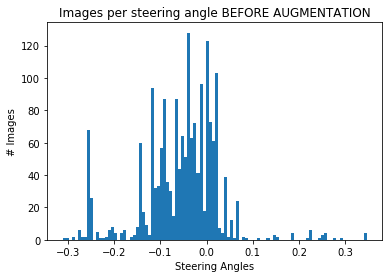

In [30]:
import matplotlib.pyplot as plt
 
print("\nExploring the dataset ...")
 
# # It plots the histogram of an arrray of angles: [0.0,0.1, ..., -0.1]
# def plot_steering_histogram(steerings, title, num_bins=100):
#     plt.hist(steerings, num_bins)
#     plt.title(title)
#     plt.xlabel('Steering Angles')
#     plt.ylabel('# Images')
#     plt.show()
 
# # It plots the histogram of an arrray of associative arrays of angles: [{'steering':0.1}, {'steering':0.2}, ..., {'steering':-0.1}]
def plot_dataset_histogram(samples, title, num_bins=100):
    steerings = []
    for item in samples:
#         print (item)
        steerings.append( float(item) )
    plot_steering_histogram(steerings, title, num_bins)

samples_before = samples_list[:,3]
# Plot the histogram of steering angles before the image augmentation
plot_dataset_histogram(samples_before, 'Images per steering angle BEFORE AUGMENTATION', num_bins=100)
samples_before = []

# Plot the histogram of steering angles after the image augmentation
plot_dataset_histogram(samples[:,1], 'Images per steering angle AFTER AUGMENTATION', num_bins=100)
print("Exploring the dataset complete.")
samples=[]



In [29]:
samples_list[:,3]

array(['0.0', '0.0', '0.0', ..., '0.04117647', '-0.02941176', '0.06470589'],
      dtype='<U44')

In [ ]:
samples_list[3]

## Defining the generator .
### This flushes the files content from disk and return it to Tensorflow for the training fit
### The generator is repeated many times ( as many Epochs of training )



In [ ]:
import cv2
import numpy as np
import sklearn


def generator(generator_samples, batch_size, shape ):
    num_samples = len(generator_samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = generator_samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                
                images.append(batch_sample[0])
                angles.append(batch_sample[1])

            # end of the batch, yield the images gathered
            yield sklearn.utils.shuffle(np.array(images) , np.array(angles))
            #return sklearn.utils.shuffle(X_train ) #, y_train)

## Model definition using Keras

#### NVIDIA model used
#### Image normalization to avoid saturation and make gradients work better.
####     Convolution: 5x5, filter: 24, strides: 2x2, activation: ELU
####     Convolution: 5x5, filter: 36, strides: 2x2, activation: ELU
####     Convolution: 5x5, filter: 48, strides: 2x2, activation: ELU
####     Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
####     Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
####     Drop out (0.5)
####     Fully connected: neurons: 100, activation: ELU
####     Fully connected: neurons: 50, activation: ELU
####     Fully connected: neurons: 10, activation: ELU
####     Fully connected: neurons: 1 (output)

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Activation, Dropout, Reshape
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
top_crop = int(resized_shape*10/100)
bottom_crop = int(resized_shape*34/100)

# Data Preprocessing ( Normalization and mean centering)
model.add(Cropping2D(cropping =((bottom_crop,top_crop),(0,0)), input_shape = (resized_shape,resized_shape,3), name ="cropping") )
model.add(Lambda(lambda x: x/127.5 - 1. , input_shape = (resized_shape,resized_shape,3)))

model.add(Conv2D(24, (5, 5), activation='elu', padding='valid',strides=(2, 2), name = "Conv1"))

model.add(Conv2D(36, (5, 5), activation='elu', padding='valid',strides=(2, 2), name = "Conv2"))

model.add(Conv2D(48, (5, 5), activation='elu', padding='valid',strides=(2, 2), name = "Conv3"))

model.add(Conv2D(64, (3, 3), activation='elu', padding='valid',strides=(1, 1), name = "Conv4"))
model.add(Conv2D(64, (3, 3), activation='elu', padding='valid',strides=(1, 1), name = "Conv5"))

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(100, activation='elu',kernel_initializer='random_uniform',bias_initializer='zeros'))
model.add(Dense(50, activation='elu',kernel_initializer='random_uniform',bias_initializer='zeros'))
model.add(Dense(10, activation='elu',kernel_initializer='random_uniform',bias_initializer='zeros'))
model.add(Dense(1,kernel_initializer='random_uniform',bias_initializer='zeros'))

model.compile(loss='mse', optimizer='adam')

print (model.summary())

### Running the training and printing a statistic

#### Defining the batch size and epochs

In [ ]:
batch_size = 32
epochs = 500

#### Creating the Train and Validation generators:

In [ ]:
train_generator      = generator(train_samples, batch_size, shape=resized_shape)
validation_generator = generator(validation_samples, batch_size, shape=resized_shape)

#### Training the model using traing_generator and validating with validation_generator

In [ ]:
from datetime import datetime
start_time = datetime.now()

model.compile(loss='mse', optimizer='adam')

numper_of_train_samples      = len(train_samples)
number_of_validation_samples = len(validation_samples) 

history_object = model.fit_generator(train_generator, steps_per_epoch= \
            numper_of_train_samples/batch_size, validation_data=validation_generator, \
            validation_steps=number_of_validation_samples/batch_size, epochs=epochs, verbose = 1)

end_time = datetime.now()
print('\nTotal number of train samples: {} ( shape {}x{})'.format(numper_of_train_samples,resized_shape,resized_shape))
print('\nBatch Size                   : {}'.format(batch_size))
print('\nDuration                     : {}'.format(end_time - start_time))

from keras.models import save_model

save_model(model, "drive.h5")
print ( "  ")
print ( " .. model saved to drive.h5 ")
print ( "  ")


### print the keys contained in the history object
print(history_object.history.keys())

import matplotlib.pyplot as plt
# # # Visualizations will be shown in the notebook.
%matplotlib inline

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()


#### Image Convolution broken down in small pieces 

### Here I am trying to visualize the Convolution Layers to understand visually how many filters I should use

In [ ]:
print (" Loading drive.h5 .......")

from keras.models import load_model
from keras.models import Model

modelobj = load_model('drive.h5')
print (" ..... model drive.h5 successfully loaded")


#### For this purpose I am loading a Test image from disk

In [ ]:
# Load test images
import cv2
import numpy as np
test_images = []

image = cv2.imread('./test_images/center1.jpg')
image = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image,(resized_shape,resized_shape ))     
test_images.append(image)


test_images = np.array(test_images)


#### First of all I am looking at the Image Crop if is well done in the right position:

In [ ]:
# Call the model to calculate an intermediate layer using the test images
layer_name = 'cropping'
intermediate_layer_model = Model(inputs=modelobj.input,
                                 outputs=modelobj.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(test_images)
intermediate_output.shape


In [ ]:
# Show the cropped images
def show_intermediate_output(image_ori, intermediate_output):
    print (intermediate_output.shape)
    depth = 0 
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20, 100))
    new_image = []
    plt.subplot(40, 5, 1 )
    plt.axis('off')
    plt.imshow(image_ori)
    for i in range(0,intermediate_output[0,0].shape[0]):
           single_output = intermediate_output[:,:,i]
#            print ( "single_output.shape {}".format(single_output.shape ))
#            print ( single_output)
           plt.subplot(40, 5, i+2 )
           plt.axis('off')
           single_output = single_output.astype(np.uint8)
           plt.imshow(single_output, cmap='gray')
    plt.show()    

    
show_intermediate_output(test_images[0], intermediate_output[0])

#### Now the FIRST convolutional layer:

In [ ]:
# Call the model to calculate an intermediate layer using the test images
layer_name = 'Conv1'
intermediate_layer_model = Model(input=model.input,
                                 output=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(test_images)
int_unNorm = (intermediate_output[0]+1) * 127.5
show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

#### Now the SECOND convolutional layer:

In [ ]:
# Call the model to calculate an intermediate layer using the test images
layer_name = 'Conv2'
intermediate_layer_model = Model(input=model.input,
                                 output=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(test_images)
int_unNorm = (intermediate_output[0]+1) * 127.5
show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

### Conv 3

In [ ]:
# Call the model to calculate an intermediate layer using the test images
layer_name = 'Conv3'
intermediate_layer_model = Model(input=model.input,
                                 output=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(test_images)
int_unNorm = (intermediate_output[0]+1) * 127.5
show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

### Conv 4

In [ ]:
# Call the model to calculate an intermediate layer using the test images
layer_name = 'Conv4'
intermediate_layer_model = Model(input=model.input,
                                 output=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(test_images)
int_unNorm = (intermediate_output[0]+1) * 127.5
show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

### Model Visualization

In [ ]:
import cv2
from keras.utils.visualize_util import plot
from keras.models import load_model
%matplotlib inline

#visualize the model
modelobj = load_model('model.h5')
plot (modelobj, to_file='model.png')
import matplotlib.pyplot as plt

plt.figure(figsize=(100, 100))
image = cv2.imread('model.png')
image = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
plt.subplot(5, 5, 1)
plt.axis('off')

plt.imshow(image)
plt.show()
